In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import healpy as hp

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
pspan = lambda mu, err : [mu-err, mu+err]

In [82]:
.35*(.65)**2

0.147875

In [87]:
def tls_to_model(tl, t10):
    tl1, tl2, tl3 = tl
    h1 = (tl1/t10)**2
    h2 = (tl2/tl1)**2
    h3 = (tl3/tl1)**2
    
    print(h1, h2, h3)
    
    base_h1 = 7.4
    base_h2 = 0.51
    base_h3 = .5
    
    base_omegab = .02
    base_omegam = .35*(.65)**2
    
    delta_h1 = base_h1 - h1
    delta_h2 = base_h2 - h2
    delta_h3 = base_h3 - h3
    
    rhs = np.array([delta_h1, delta_h2, delta_h3])
    lhs = np.array([[.4, -.5], [-.64, .14], [-.31, .53]])
    (domegab, domegam), _, _, _ = np.linalg.lstsq(lhs, rhs, rcond=None)
    
    our_omegab = base_omegab*(1+domegab)
    our_omegam = base_omegam*(1+domegam)
    
    noh_omegab = our_omegab/((.7)**2)
    noh_omegam = our_omegam/((.7)**2)
    
    return noh_omegab, noh_omegam

In [5]:
fullmap = fits.open('./data/COM_CMB_IQU-smica_2048_R3.00_hm1.fits')
idata = fullmap[1].data["I_STOKES"]

fullmap has temperature (I) and polarization (Q,U) data as well. We can use this in the future to make nicer looking graphs if we want

In [6]:
# Check headers if you want
# fullmap[1].header;

Plotting spherical functions is very easy using healpy (python port of healpix)

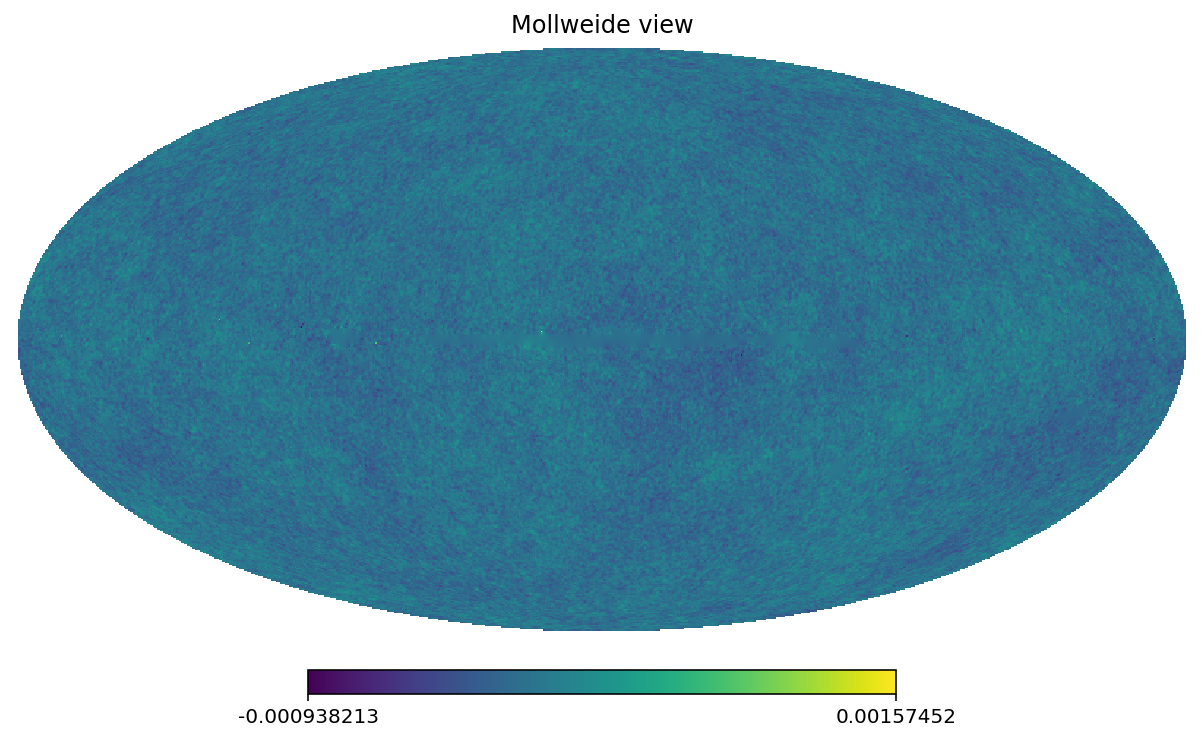

In [7]:
hp.mollview(idata, nest=True)

Data is given using "NESTED" ordering and we need it in "RING" (for anafast)

In [8]:
# Data is given using "NESTED" ordering
# we need it in RING to use anafast later on
ring_data = hp.reorder(idata, inp='NESTED', out='RING')

There is a lot of data! For testing purposes, lower the quality down but we should not use this when actually doing analysis!

In [9]:
# Leo - make sure you get it working with this line in place, 
# and then comment this out and see if you can get it working
# on ring_data directly. 
lesspretty = hp.ud_grade(ring_data, 512)

Anafast does the power spectrum job!

In [10]:
# Leo - This feels a bit cheaty but works wonders.
# If you have some time, try reading up on spherical 
# harmonics and we can work on our implementation.
# There is a "gal_cut" argument you can try playing 
# with to remove the blob in the center of the plot above.

clfast = hp.anafast(lesspretty)

In [11]:
# The first two are extremely small! Monopole/dipole term
# Get rid of them for plotting purposes
badmonodip = 2
clclean = clfast[badmonodip:]
cleanlens = len(clclean)

In [12]:
ls = np.arange(badmonodip,cleanlens+badmonodip)
fixedcls = np.sqrt(clclean*ls*(ls+1)/(2*np.pi))

In [60]:
peak1 = [220, 20]
peak2 = [530, 20]
peak3 = [800, 20]
peaks = np.array([peak1, peak2, peak3])

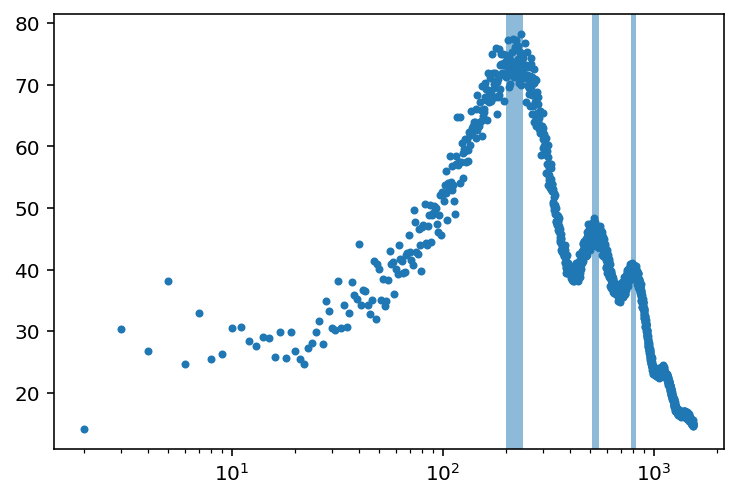

In [61]:
plt.plot(ls, fixedcls*1e6, '.')
# plt.semilogy()
plt.semilogx()
for p in peaks:
    plt.axvspan(*pspan(*p), alpha=.5)

In [72]:
t10_d = fixedcls[10]
t10 = np.mean(fixedcls[8:15])
t10_e = np.std(fixedcls[8:15])/np.sqrt(7)

In [73]:
tls_d = fixedcls[peaks[:,0]]
tls = np.array([np.mean(fixedcls[pspan(*p)[0]:pspan(*p)[1]]) for p in peaks])
tls_err = np.array([np.std(fixedcls[pspan(*p)[0]:pspan(*p)[1]])/np.sqrt(p[1]*2) for p in peaks])

In [74]:
tls

array([7.35324583e-05, 4.57285379e-05, 3.97434185e-05])

In [89]:
tls_to_model(tls_d, t10_d)

7.427961272217131 0.3473092832714963 0.26825511164736127


(0.03303419207838514, 0.341826737145164)

In [76]:
max_samples = 1000
sample_omegab = np.zeros(max_samples)
sample_omegam = np.zeros(max_samples)

In [77]:
for i in range(max_samples):
    new_sample = np.random.default_rng().normal(tls, tls_err, 3)
    new_t10 = np.random.default_rng().normal(t10, t10_e)
    s_ob, s_om = tls_to_model(new_sample, new_t10)
    sample_omegab[i] = s_ob
    sample_omegam[i] = s_om

In [78]:
print("Omega_b", np.mean(sample_omegab), np.std(sample_omegab))
print("Omega_m",np.mean(sample_omegam), np.std(sample_omegam))

Omega_b 0.034004941164499786 0.0005186071000737202
Omega_m 0.10057651454525289 0.0779673789344184


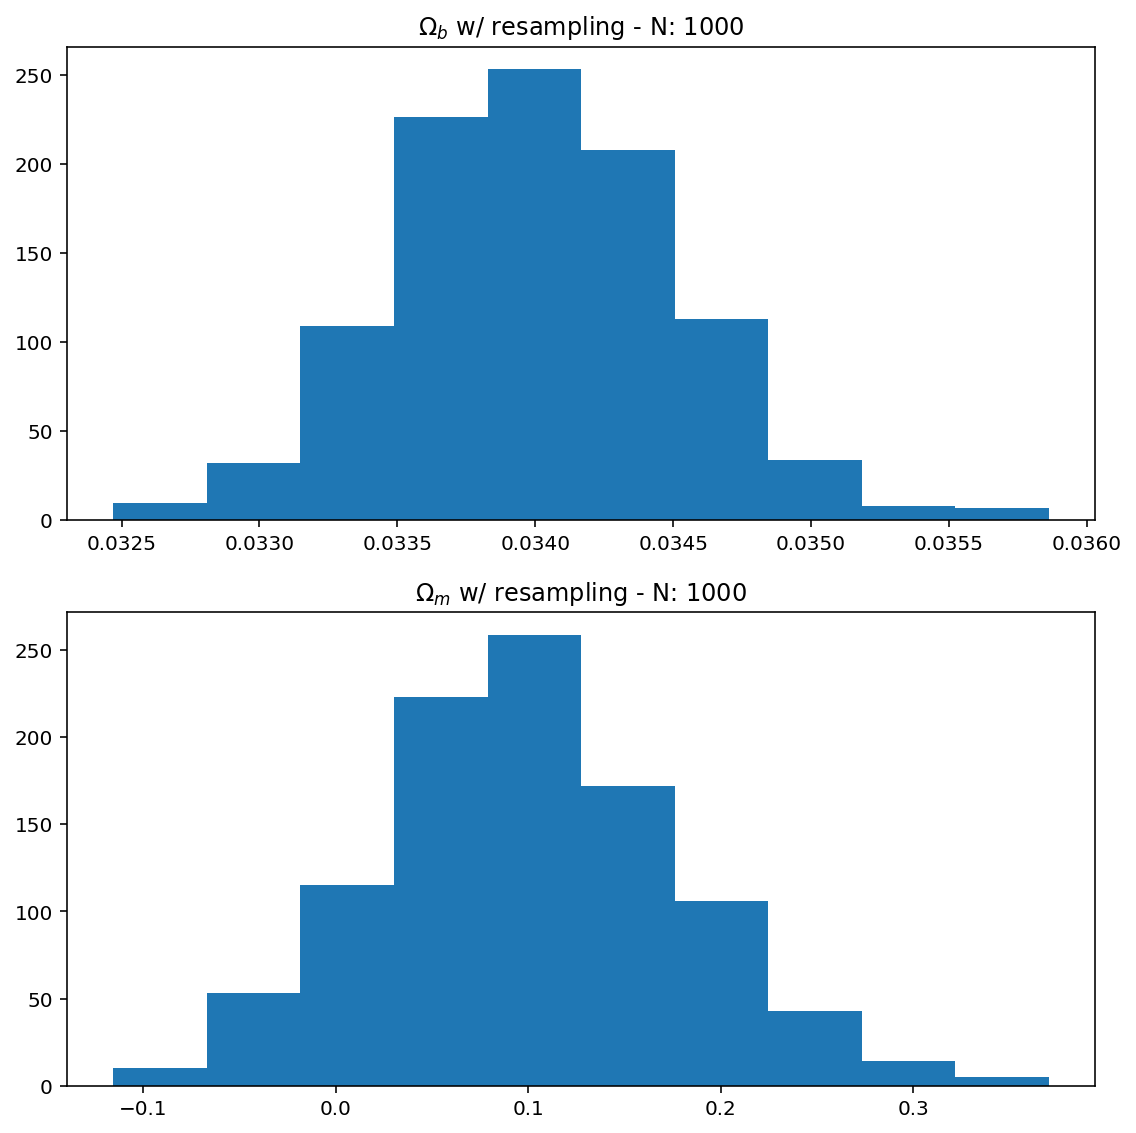

In [79]:
fig, ax = plt.subplots(2, figsize=(8,8))
ax[0].hist(sample_omegab)
ax[0].set_title(r"$\Omega_b$ w/ resampling - N: " + str(max_samples))

ax[1].hist(sample_omegam)
ax[1].set_title(r"$\Omega_m$ w/ resampling - N: " + str(max_samples))

plt.tight_layout();

In [26]:
print(np.mean(sample_omegam), np.std(sample_omegam))

0.10340343944678092 0.23553705379235942
